In [4]:
#Loading of the necessary libraries
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [29]:
#will give your pc a unique id stored in config.txt, please do not remove this file once created
from library.get_id import get_or_create_unique_id

my_id = get_or_create_unique_id()
print("my ID:", my_id)

my ID: 89ff95f0-acdf-4dd7-a4fa-b382d7c59fd9


In [30]:
#fixes the seed, we want to avoid that for training as this will prevent exploration
#torch.manual_seed(42)

In [31]:
#will try and get the most appropriate device for training
from library.get_device import get_device

device = get_device(no_print=False)

Using DirectML device


In [32]:
#Data preprocessing & augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [33]:
#Data preprocessing & augmentation for testing
test_transform =transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [34]:
#loading of the dataset
data_dir = "./kaggle/input/brain-tumor/4 classes"
dataset = ImageFolder(root=data_dir, transform=train_transform)

In [35]:
# Split dataset (70-15-15 split)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [36]:
#assign the preprocessing to the different sets
val_dataset.dataset.tranform = test_transform
test_dataset.dataset.transform = test_transform

In [37]:
# Define CNN Model
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4, dropout=0.5):
        super(BrainTumorCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
#Initialize the hyperparameters:
class HyperParameters():
    def __init__(self,
                 learning_rate = 0.001,
                 batch_size = 32,
                 epochs = 10,
                 dropout = 0.5,
                 optimizer_type = "adam"
                 ) -> None:
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.dropout = dropout
        self.optimizer_type = optimizer_type
        
    def build_model(self, device):
        return BrainTumorCNN(num_classes=4, dropout=self.dropout).to(device)

    def build_optimizer(self, model):
        if self.optimizer_type == "adam":
            return optim.Adam(model.parameters(), lr=self.learning_rate)
        elif self.optimizer_type == "sgd":
            return optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.9)
        else:
            raise ValueError(f"Unknown optimizer type: '{self.optimizer_type}'. "
                         f"Supported types: 'adam', 'sgd'.")

    def build_criterion(self):
        return nn.CrossEntropyLoss()

In [17]:
hyperParameters = HyperParameters()
model = hyperParameters.build_model(device)
criterion = hyperParameters.build_criterion()
optimizer = hyperParameters.build_optimizer(model)

In [18]:
#assigns the loaders to the sets
train_loader = DataLoader(train_dataset, batch_size=hyperParameters.batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=hyperParameters.batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=hyperParameters.batch_size, shuffle=False, num_workers=2)

In [ ]:
#resets the losses & accuracies
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

#generates a unique id for the run
from library.get_id import get_unique_run_id
run_id = get_unique_run_id()

#trains & measures the model
for epoch in range(hyperParameters.epochs):
    start_time = time.time()  # start timer
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{hyperParameters.epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f}s")

Epoch [1/10], Train Loss: 0.0587, Train Acc: 97.97%, Val Loss: 0.7630, Val Acc: 83.19%, Time: 18.86s
Epoch [2/10], Train Loss: 0.0743, Train Acc: 97.97%, Val Loss: 0.6014, Val Acc: 87.50%, Time: 19.00s
Epoch [3/10], Train Loss: 0.0467, Train Acc: 98.62%, Val Loss: 0.7992, Val Acc: 84.70%, Time: 18.92s
Epoch [4/10], Train Loss: 0.0329, Train Acc: 99.12%, Val Loss: 0.9144, Val Acc: 83.41%, Time: 20.19s
Epoch [5/10], Train Loss: 0.0340, Train Acc: 98.94%, Val Loss: 0.6930, Val Acc: 86.42%, Time: 19.77s
Epoch [6/10], Train Loss: 0.0259, Train Acc: 99.31%, Val Loss: 0.8475, Val Acc: 87.93%, Time: 21.92s
Epoch [7/10], Train Loss: 0.0212, Train Acc: 99.31%, Val Loss: 0.8395, Val Acc: 87.72%, Time: 22.48s
Epoch [8/10], Train Loss: 0.0304, Train Acc: 99.12%, Val Loss: 0.8372, Val Acc: 84.48%, Time: 20.01s
Epoch [9/10], Train Loss: 0.0267, Train Acc: 99.22%, Val Loss: 0.8030, Val Acc: 85.34%, Time: 20.25s
Epoch [10/10], Train Loss: 0.0209, Train Acc: 99.26%, Val Loss: 0.8485, Val Acc: 87.07%, Ti

In [47]:
# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 83.44%


In [ ]:
results = {
        'computer_id': my_id,
        'run_id': run_id,
        'train_accuracies': train_accuracies,
        'train_losses': train_losses,
        'val_accuracies': val_accuracies,
        'val_losses': val_losses,
        'learning_rate': hyperParameters.learning_rate,
        'batch_size': hyperParameters.batch_size,
        'epochs': hyperParameters.epochs,
        'dropout': hyperParameters.dropout,
        'optimizer_type': hyperParameters.optimizer_type,
        'test_accuracy': test_acc
    }

In [52]:

print(len(results['train_losses']),results)


20 {'computer_id': '89ff95f0-acdf-4dd7-a4fa-b382d7c59fd9', 'run_id': '8f8122c0-a602-411f-b3cd-1410247c5764', 'train_accuracies': [49.46931241347485, 67.60498384863867, 78.91093677895708, 86.2021227503461, 89.75542224273188, 93.30872173511767, 94.6931241347485, 97.18504845408398, 97.78495616059068, 98.24642362713429, 97.96954314720813, 97.96954314720813, 98.61559760036917, 99.12321181356714, 98.9386248269497, 99.30779880018459, 99.30779880018459, 99.12321181356714, 99.21550530687587, 99.26165205353023], 'train_losses': [1.3093937512706308, 0.7918494203511406, 0.5530308029230904, 0.3923887713428806, 0.2752369553508127, 0.17642231652622714, 0.13984529723358505, 0.08456452575731366, 0.06868204387480065, 0.05966502894400893, 0.058717691271928794, 0.07430266076014103, 0.04666113584329758, 0.03288461349695675, 0.0340095895311713, 0.02593895417436108, 0.021219011759967543, 0.030356838672934615, 0.026704164133287335, 0.020906653183320648], 'val_accuracies': [57.11206896551724, 74.13793103448276

In [50]:
from library.save_results import save_training_results_to_csv

save_training_results_to_csv(results)

ValueError: All arrays must be of the same length

In [22]:
# Save the Model
# torch.save(model.state_dict(), "brain_tumor.pth")

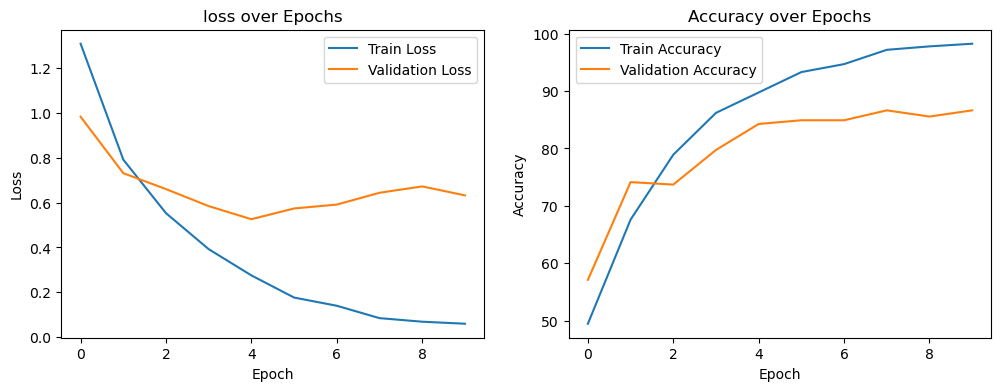

In [23]:
# Plot Training and Validation Metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()